In [33]:
# Import packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
#from cvxopt import matrix, solvers
from scipy.optimize import minimize

In [34]:
# Read data into pandas
japan = pd.read_excel("./data/Price History_EWJ_Japan_Equity.xlsx")
t_bills_7_10 = pd.read_excel("./data/Price History_7-10_US_TBills.xlsx")
t_bills_20 = pd.read_excel("./data/Price History_20+_US_TBills.xlsx")
apac_x_japan = pd.read_excel("./data/Price History_EPP_APACxJapan_Equity.xlsx")
europe = pd.read_excel("./data/Price History_IEV_Europe_Equity.xlsx")
latam = pd.read_excel("./data/Price History_ILF_LatAm_Equity.xlsx")
us = pd.read_excel("./data/Price History_IVV_US_Equity.xlsx")
gold = pd.read_excel("./data/Price History_IAU_Gold_Trust.xlsx")

In [35]:
def preprocess_and_rename(df, name):
    df['Exchange Date'] = pd.to_datetime(df['Exchange Date'])
    df.set_index('Exchange Date', inplace=True)
    df.rename(columns={'%Chg':f'Return {name}'}, inplace=True)
    return df[[f'Return {name}']]

# Preprocess all datasets and rename columns
japan = preprocess_and_rename(japan, 'Japan')
t_bills_7_10 = preprocess_and_rename(t_bills_7_10, 'T-Bills_7_10')
t_bills_20 = preprocess_and_rename(t_bills_20, 'T-Bills_20')
apac_x_japan = preprocess_and_rename(apac_x_japan, 'APACxJapan')
europe = preprocess_and_rename(europe, 'Europe')
latam = preprocess_and_rename(latam, 'LatAm')
us = preprocess_and_rename(us, 'US')
gold = preprocess_and_rename(gold, 'Gold')

In [36]:
apac_x_japan

,Return APACxJapan
Exchange Date,
2024-12-13,-0.003433
2024-12-12,-0.011694
2024-12-11,-0.001268
2024-12-10,-0.016139
2024-12-09,0.018978
...,...
2005-01-07,0.000806
2005-01-06,-0.006293
2005-01-05,-0.009632


In [37]:
# Merge all datasets on 'Exchange Date'
returns = japan.join([t_bills_7_10, t_bills_20, apac_x_japan, europe, latam, us, gold], how='inner')

# Rename the columns for clarity
returns.columns = ['Japan', 'T-Bills_7_10', 'T-Bills_20', 
                'APACxJapan','Europe','LatAm', 'US', 'Gold']
returns = returns.dropna()
returns = returns.sort_values(by='Exchange Date', ascending=True)

In [38]:
returns

,Japan,T-Bills_7_10,T-Bills_20,APACxJapan,Europe,LatAm,US,Gold
Exchange Date,,,,,,,,
2005-01-31,0.004744,0.000491,0.003217,0.003817,0.008907,0.018682,0.008956,-0.009838
2005-02-01,-0.005666,-0.000115,-0.000530,-0.002013,0.006112,0.013754,0.006425,-0.003549
2005-02-02,0.004748,-0.000220,0.001214,0.005939,0.004995,0.006156,0.003192,0.002612
2005-02-03,-0.010397,-0.001690,0.000378,-0.003342,-0.007119,0.010988,-0.001758,-0.012077
2005-02-04,0.006686,0.005762,0.013300,0.005588,0.008929,0.016426,0.009646,-0.005273
...,...,...,...,...,...,...,...,...
2024-12-09,-0.007921,-0.002991,-0.008365,0.018978,-0.000381,0.012039,-0.005157,0.009863
2024-12-10,-0.006082,-0.002112,-0.005163,-0.016139,-0.009207,0.002292,-0.002896,0.013155
2024-12-11,0.013895,-0.002776,-0.009999,-0.001268,0.004358,0.015587,0.007707,0.009247


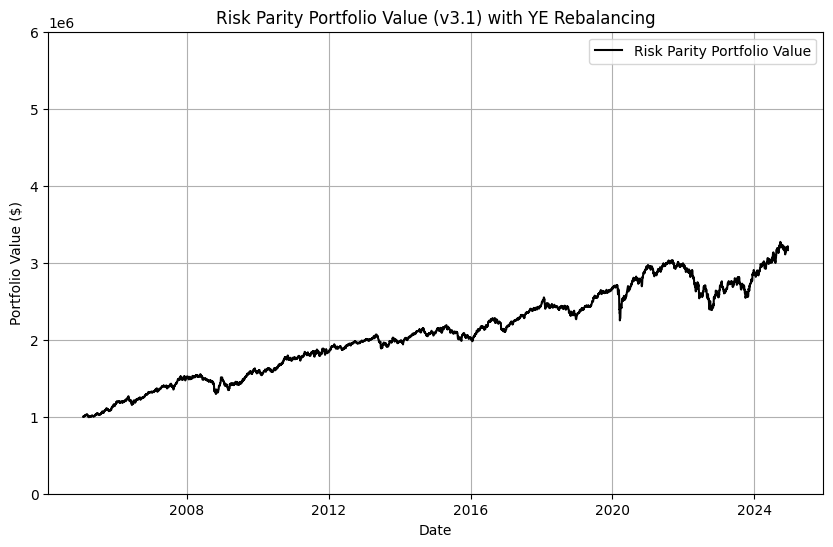

Final Portfolio Value: $3,164,153.71


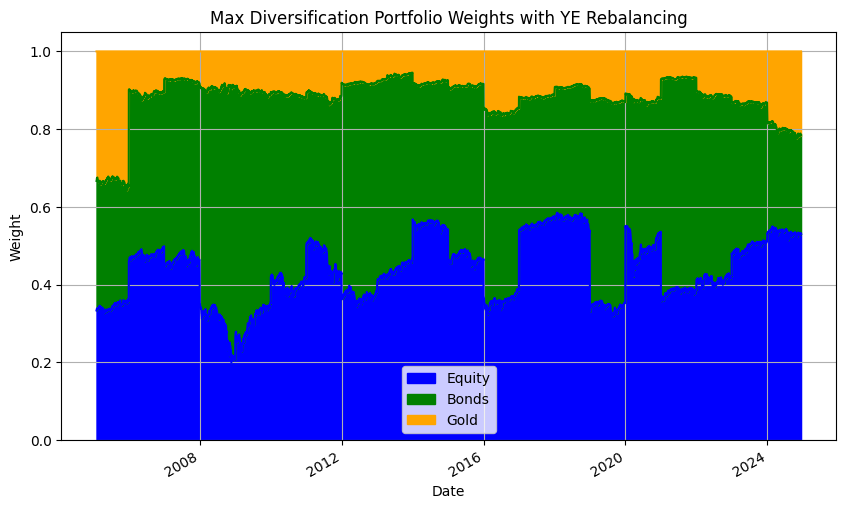

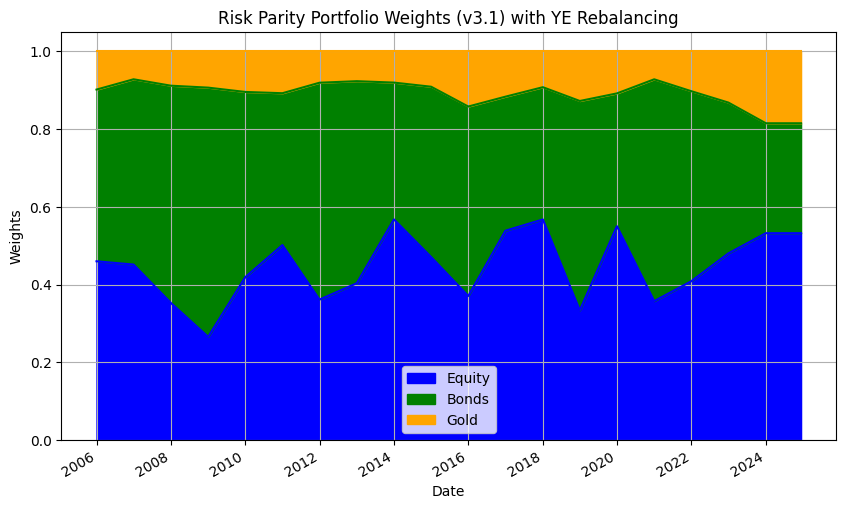

In [39]:
#### Risk Parity Portfolio Construction #### ver 3.1

# Variables
rebalance_frequency = 'YE'  # 'ME' = monthly, 'QE' = quarterly, 'YE' = yearly
#YE best ftol = 1e-4, ME best ftol = 1e-2
initial_investment = 1000000
lookback_days = 180
tc_rate = 0.001

def calculate_portfolio_variance(weights, cov_matrix):
    return np.dot(weights.T, np.dot(cov_matrix, weights))

def calculate_risk_contribution(weights, cov_matrix):
    port_var = calculate_portfolio_variance(weights, cov_matrix)
    marginal_contrib = np.dot(cov_matrix, weights)
    # Normalized risk contributions
    risk_contrib = np.multiply(weights, marginal_contrib) / port_var
    return risk_contrib

def risk_parity_objective(weights, cov_matrix):
    risk_contrib = calculate_risk_contribution(weights, cov_matrix)
    target_risk = np.mean(risk_contrib)  # target: equal risk = 1/n_assets
    return np.sum((risk_contrib - target_risk) ** 2)

def risk_parity_optimizer(cov_matrix, w0, n_assets):
    cons = ({'type': 'eq', 'fun': lambda w: np.sum(w) - 1},)
    bounds = [(0, 1)] * n_assets
    options = {'maxiter': 1000, 'ftol': 1e-4, 'disp': False}
    res = minimize(risk_parity_objective, w0, args=(cov_matrix,),
                   bounds=bounds, constraints=cons, method='SLSQP', options=options)
    return res


def risk_parity_construction(returns, rebalance_frequency):
    # Define assets and initial equal weights
    assets = ['Japan', 'T-Bills_7_10', 'T-Bills_20', 'APACxJapan', 'Europe', 'LatAm', 'US', 'Gold']
    returns = returns[assets]
    n_assets = len(assets)
    w0 = np.array([1/15, 1/6, 1/6, 1/15, 1/15, 1/15, 1/15, 1/3])

    # Determine rebalancing dates (aligned to trading days)
    rebal_dates = returns.resample(rebalance_frequency).last().index
    rebal_dates = returns.index[returns.index.get_indexer(rebal_dates, method='nearest')]

    # Initialize individual asset values, overall portfolio value, and portfolio weights
    asset_vals = {asset: pd.Series(index=returns.index, dtype=float) for asset in assets}
    for asset, weight in zip(assets, w0):
        asset_vals[asset].iloc[0] = initial_investment * weight
    portfolio_val = pd.Series(index=returns.index, dtype=float)
    portfolio_val.iloc[0] = initial_investment
    portfolio_weights = pd.DataFrame(index=rebal_dates, columns=assets, dtype=float)
    if len(rebal_dates) > 0:
        portfolio_weights.iloc[0] = w0

    # Track transaction costs and turnover
    tx_costs = pd.Series(0.0, index=returns.index)
    turnover_series = pd.Series(0.0, index=returns.index)

    # Loop over rebalancing periods
    for i, rebal_date in enumerate(rebal_dates):
        prev_date = returns.index[0] if i == 0 else rebal_dates[i - 1]
        period = returns.loc[prev_date:rebal_date].index

        # Daily update: compound individual asset returns
        for t in period[1:]:
            for asset in assets:
                prev_t = period[period.get_loc(t) - 1]
                asset_vals[asset].loc[t] = asset_vals[asset].loc[prev_t] * (1 + returns[asset].loc[t])
            portfolio_val.loc[t] = sum(asset_vals[a].loc[t] for a in assets)

        # Rebalancing step (if not at final period)
        if i < len(rebal_dates) - 1:
            total = portfolio_val.loc[rebal_date]

            # Estimate covariance matrix using lookback window
            cov_start = rebal_date - pd.Timedelta(days=lookback_days)
            cov_data = returns.loc[cov_start:rebal_date]
            if cov_data.shape[0] < 2:
                print(f"Insufficient data for covariance estimation at {rebal_date}. Skipping rebalancing.")
                continue
            cov_matrix = cov_data.cov().values

            # Optimize risk parity weights using the normalized objective (v2.2)
            res = risk_parity_optimizer(cov_matrix, w0, n_assets)
            if not res.success:
                print(f"Optimization failed at {rebal_date}. Using previous weights.")
                optimal_weights = w0
            else:
                optimal_weights = res.x
            w0 = optimal_weights  # Update for next period
            portfolio_weights.loc[rebal_date] = w0

            # Calculate transaction costs and turnover
            target_vals = {asset: total * w for asset, w in zip(assets, w0)}
            trades = {asset: abs(target_vals[asset] - asset_vals[asset].loc[rebal_date]) for asset in assets}
            total_traded = sum(trades.values())
            turnover = total_traded / total
            cost = tc_rate * total_traded
            tx_costs.loc[rebal_date] = cost
            turnover_series.loc[rebal_date] = turnover

            total_adj = total - cost  # Adjust for transaction cost

            # Rebalance: reset individual asset values according to new weights
            for idx, asset in enumerate(assets):
                asset_vals[asset].loc[rebal_date] = total_adj * w0[idx]
            portfolio_val.loc[rebal_date] = total_adj

    # After finishing rebalancing loop, fill missing final weights
    if portfolio_weights.iloc[-1].isna().any():
       portfolio_weights.iloc[-1] = w0  # use last computed weights

    # Update portfolio beyond final rebalancing date
    if len(rebal_dates) > 0:
        final_rebal = rebal_dates[-1]
        period = returns.loc[final_rebal:].index
        for t in period[1:]:
            for asset in assets:
                prev_t = period[period.get_loc(t) - 1]
                asset_vals[asset].loc[t] = asset_vals[asset].loc[prev_t] * (1 + returns[asset].loc[t])
            portfolio_val.loc[t] = sum(asset_vals[a].loc[t] for a in assets)
    else:
        for t in returns.index[1:]:
            for asset in assets:
                prev_t = returns.index[returns.index.get_loc(t) - 1]
                asset_vals[asset].loc[t] = asset_vals[asset].loc[prev_t] * (1 + returns[asset].loc[t])
            portfolio_val.loc[t] = sum(asset_vals[a].loc[t] for a in assets)

    return portfolio_val, portfolio_weights, asset_vals, tx_costs, turnover_series

# --- Function Call and Plotting for Risk Parity Portfolio ---
portfolio_val, portfolio_weights, asset_vals, tx_costs, turnover_series = risk_parity_construction(returns, rebalance_frequency)

plt.figure(figsize=(10,6))
plt.plot(portfolio_val, label='Risk Parity Portfolio Value', color='black')
plt.title(f'Risk Parity Portfolio Value (v3.1) with {rebalance_frequency} Rebalancing')
plt.xlabel('Date')
plt.ylabel('Portfolio Value ($)')
plt.ylim(0, 6000000)
plt.legend()
plt.grid(True)
plt.show()

print(f"Final Portfolio Value: ${portfolio_val.iloc[-1]:,.2f}")

# Compute daily weights for each asset
daily_weights = pd.DataFrame(index=portfolio_val.index)
for asset in asset_vals:
    daily_weights[asset] = asset_vals[asset] / portfolio_val

# Group daily weights by asset class
grouped_daily_weights = pd.DataFrame(index=daily_weights.index)
grouped_daily_weights['Equity'] = daily_weights[['Japan', 'APACxJapan', 'Europe', 'LatAm', 'US']].sum(axis=1)
grouped_daily_weights['Bonds'] = daily_weights[['T-Bills_7_10', 'T-Bills_20']].sum(axis=1)
grouped_daily_weights['Gold'] = daily_weights['Gold']

# Plot daily asset class weights as a stacked area chart
grouped_daily_weights.plot(figsize=(10,6), kind='area', stacked=True, color=['blue','green','orange'])
plt.title(f'Max Diversification Portfolio Weights with {rebalance_frequency} Rebalancing')
plt.xlabel('Date')
plt.ylabel('Weight')
plt.grid(True)
plt.show()

# (Optional) Group asset weights by asset class and plot
grouped_weights = pd.DataFrame(index=portfolio_weights.index)
grouped_weights['Equity'] = portfolio_weights[['Japan', 'APACxJapan', 'Europe', 'LatAm', 'US']].sum(axis=1)
grouped_weights['Bonds'] = portfolio_weights[['T-Bills_7_10', 'T-Bills_20']].sum(axis=1)
grouped_weights['Gold'] = portfolio_weights['Gold']
grouped_weights.plot(figsize=(10,6), kind='area', stacked=True, color=['blue','green','orange'])
plt.title(f'Risk Parity Portfolio Weights (v3.1) with {rebalance_frequency} Rebalancing')
plt.xlabel('Date')
plt.ylabel('Weights')
plt.grid(True)
plt.show()


In [40]:
#### Risk Parity Portfolio Analytics #### ver 3.0

# 1) Resample portfolio value to monthly frequency and compute monthly returns
monthly_pf = portfolio_val.resample('ME').ffill()
monthly_rets = monthly_pf.pct_change().dropna()

# 2) Compute annualized volatility from monthly std deviation
annual_vol = monthly_rets.std() * np.sqrt(12)

# 3) Total return & geometric averages
initial_val = portfolio_val.iloc[0]
final_val = portfolio_val.iloc[-1]
total_ret = final_val / initial_val - 1
n_months = len(monthly_rets)
geo_avg_month = (final_val / initial_val) ** (1 / n_months) - 1
geo_avg_year = (1 + geo_avg_month) ** 12 - 1

# 4) Sharpe Ratio: annualized arithmetic return divided by annualized volatility
ann_arith_ret = monthly_rets.mean() * 12
sharpe = ann_arith_ret / annual_vol

# 5) Monthly 99% VaR (using 1st percentile)
var_99 = monthly_rets.quantile(0.01)

# 6) Portfolio Turnover: total turnover and average annual turnover
total_turnover = turnover_series.sum()
n_years = (turnover_series.index[-1] - turnover_series.index[0]).days / 365
avg_annual_turnover = total_turnover / n_years

# 7) Total transaction cost over the period
total_tx_cost = tx_costs.sum()

# 8) Print results
print("### Max Div Portfolio Analytics ###")
print(f"Annualized monthly volatility: {annual_vol:.4f}")
print(f"Total return: {total_ret * 100:.2f}%")
print(f"Geometric avg monthly return (CAGR basis): {geo_avg_month * 100:.2f}%")
print(f"Geometric avg yearly return (CAGR basis): {geo_avg_year * 100:.2f}%")
print(f"Sharpe Ratio: {sharpe:.2f}")
print(f"Monthly 99% Value at Risk (VaR): {var_99:.4f}")
print(f"Average Annual Portfolio Turnover: {avg_annual_turnover * 100:.2f}%")
print(f"Total transaction cost over entire period: ${total_tx_cost:,.2f}")


### Max Div Portfolio Analytics ###
Annualized monthly volatility: 0.0851
Total return: 216.42%
Geometric avg monthly return (CAGR basis): 0.48%
Geometric avg yearly return (CAGR basis): 5.95%
Sharpe Ratio: 0.72
Monthly 99% Value at Risk (VaR): -0.0633
Average Annual Portfolio Turnover: 24.23%
Total transaction cost over entire period: $10,064.24
